# Thesis EDA

Last updated: 03/09/2023


### Research Question and Hypothesis 

**Research question:**

How do buyer preferences change after Covid-19?

**Specific aims:**

1. Assess hedonic model coefficient changes over time. In the hedonic model, independent variables are vectors of attributes related to structural, locational, and neighborhood factors. 
2. Assess Random Forest feature importance changes over time. This approach is robust to spatial autocorrelation, handles interactions between dependent variables better than OLS, and allows for nonlinear relationships.
3. Compare the two approaches and determine which should be used. 

**Hypothesis:**

Neighborhoods matter more after Covid-19 because of the re-conception of the idea of neighborhood.
Increased social stratification across space.


### Contents

1. [Import modules and data](#bullet1)

What's been done so far:
Data joined between sales data and PLUTO data.
Data types cleared up.

2. [EDA and preprocessing](#bullet2)

Visualize univariate dist. (sale price, sale price over time)
Visualize bivariate dist. (sale price x some of the more important predictors based on the lit, colored by time)

Run KMeans to visualize clusters.

(Would I ever want to split into 2 datasets along intrinsic and extrinsic factors and run PCA on each and then compare?)
((Which are the most important features for each group?))

*Train set: first 70% of data points chronologically
*Test set: last whatever % of data points chronologically

3. [Hedonic OLS model (or GMA?)](#bullet3)

This is the traditional model.
Score model, get feature importances.

4. [Random Forest model](#bullet4)

5. [Hedonic model coeffs over time](#bullet5)

6. [Random Forest feature importances over time](#bullet6)

7. [Compare results](#bullet7)



<a class="anchor" id="bullet1"></a>

#### 1. Import modules and data. <a class="anchor" id="bullet1"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Data/new.csv", index_col=0, low_memory=False)

print("Column counts of each dtype:")
print(pd.DataFrame(df.dtypes).sort_values(0).value_counts())

Column counts of each dtype:
float64    73
object     38
int64       4
dtype: int64


##### Clean columns

###### Drop fully missing columns

In [6]:
#quantify missingness, drop columns that are all missing

print(len(df_renamed.columns))
df_renamed = df_renamed.dropna(how='all', axis=1)
print(len(df_renamed.columns))

107
104


###### Drop duplicate columns

In [5]:
df_renamed = df.copy()

#lowercase all letters
df_renamed.columns = map(str.lower, df_renamed.columns)
#get rid of enters and spaces
df_renamed.columns = [i.replace('\n', " ").replace("  ", " ") for i in df_renamed.columns]

print("total columns: {}".format(len(df_renamed.columns)))
print("unique columns: {}".format(len(df_renamed.columns.unique())))

not_unique = []
for i in list(df_renamed.columns):
    if list(df_renamed.columns).count(i) != 1:
        not_unique.append(i)
print("non unique columns: {}".format(not_unique))


# DROP DUPLICATES

df_renamed = df_renamed.drop(columns=not_unique, axis=1)

#ALPHABETIZE

df_renamed = df_renamed.reindex(sorted(df_renamed.columns), axis=1)

list(df_renamed.columns)

total columns: 115
unique columns: 111
non unique columns: ['borough', 'block', 'lot', 'address', 'borough', 'block', 'lot', 'address']


['apartment number',
 'appbbl',
 'appdate',
 'areasource',
 'assessland',
 'assesstot',
 'bbl',
 'bct2020',
 'bctcb2020',
 'bldgarea',
 'bldgclass',
 'bldgdepth',
 'bldgfront',
 'borocode',
 'bsmtcode',
 'building class at present',
 'building class at time of sale',
 'building class category',
 'builtfar',
 'cb2010',
 'cd',
 'comarea',
 'commercial units',
 'commfar',
 'condono',
 'council',
 'ct2010',
 'dcpedited',
 'ease-ment',
 'easements',
 'edesignum',
 'exempttot',
 'ext',
 'facilfar',
 'factryarea',
 'firecomp',
 'firm07_flag',
 'garagearea',
 'gross square feet',
 'healtharea',
 'healthcenterdistrict',
 'histdist',
 'irrlotcode',
 'land square feet',
 'landmark',
 'landuse',
 'latitude',
 'longitude',
 'lotarea',
 'lotdepth',
 'lotfront',
 'lottype',
 'ltdheight',
 'neighborhood',
 'notes',
 'numbldgs',
 'numfloors',
 'officearea',
 'otherarea',
 'overlay1',
 'overlay2',
 'ownername',
 'ownertype',
 'pfirm15_flag',
 'plutomapid',
 'policeprct',
 'proxcode',
 'resarea',
 'resid

In [ ]:
# drop collinear cols


#drop irrelevant
#df_renamed = df_renamed.drop(columns=['appbbl', 'building class at present', ], axis=1)
## appbbl == bbl
## building class at present is irrelevant
## ease-ment == easements
## xcoord == latitude
## ycoord == longtiude

###### Missingness

In [7]:
#MISSING: SALE PRICE 

import math
problematic_vals = [0, 1, math.e]

non_missing_obs = []
missing_obs = []

for i in df_renamed.index:
    if df_renamed['saleprice'][i] in problematic_vals:
        missing_obs.append(i)
    else:
        non_missing_obs.append(i)
        
print(len(non_missing_obs))
print(len(missing_obs))

88224
22002


In [8]:
df.saleprice.describe()

count    1.102260e+05
mean     3.138684e+06
std      2.245199e+07
min      0.000000e+00
25%      3.550000e+05
50%      8.750000e+05
75%      2.000000e+06
max      2.397502e+09
Name: saleprice, dtype: float64

In [9]:
df_non_missing = df_renamed.loc[(df_renamed['saleprice'] != 0)]
df_missing = df_renamed.loc[(df_renamed['saleprice'] == 0)]


print(df_non_missing.shape)
print(df_missing.shape)

non_missing_stats = pd.DataFrame(df_non_missing.describe().T)
missing_stats = pd.DataFrame(df_missing.describe().T)
labels = non_missing_stats.columns
print(labels)

non_missing_stats

diff_cast = non_missing_stats - missing_stats

diff_cast

(88439, 104)
(21787, 104)
Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
appbbl,1354.0,-8.401730e+05,-6.546830e+05,140002.0,-344997.00,140000.5,-1627449.25,-20333.0
areasource,35396.0,-6.793271e-02,-3.103879e-01,-2.0,0.00,0.0,0.00,0.0
assessland,35396.0,5.494689e+05,3.363468e+06,0.0,255487.50,614250.0,427500.00,29859300.0
assesstot,35396.0,3.931040e+06,9.281836e+06,0.0,1714950.00,5001750.0,4919400.00,303936750.0
bbl,35397.0,-2.119868e+05,-4.588606e+05,30008.0,370015.25,-120023.0,-607457.00,0.0
...,...,...,...,...,...,...,...,...
yearalter1,35396.0,9.135776e+01,-1.129542e+01,0.0,0.00,3.0,-1.00,0.0
yearalter2,35396.0,-1.996989e+01,-3.474295e+01,0.0,0.00,0.0,0.00,0.0
yearbuilt,35396.0,3.322411e+01,-1.121518e+02,0.0,11.00,6.0,4.00,0.0
zip code,66652.0,-9.547954e+00,1.283808e+02,0.0,0.00,0.0,0.00,0.0


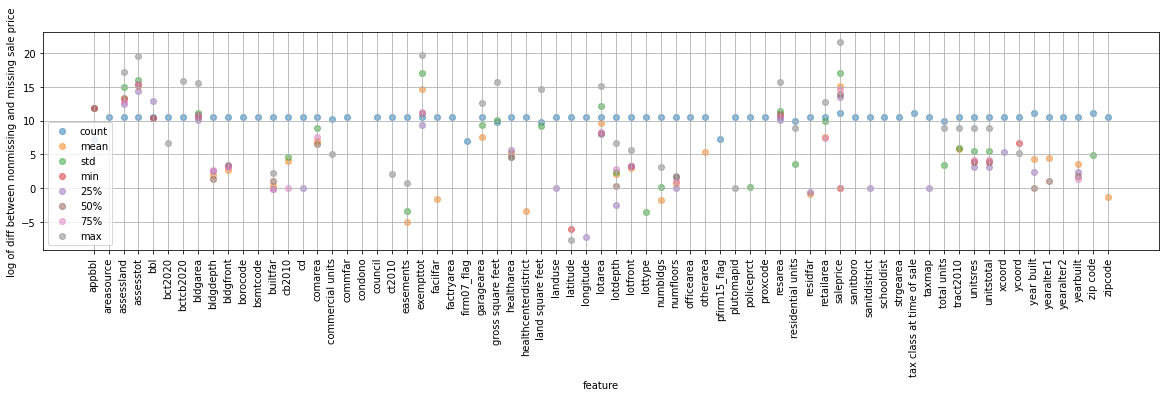

In [10]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(20, 4))
for i in labels:
    plt.scatter(diff_cast.index, np.log(diff_cast[i]), label=i, alpha=0.5)
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.xlabel('feature')
plt.ylabel('log of diff between nonmissing and missing sale price')
plt.savefig('Viz_output/missing vs nonmissing.png')
plt.show()

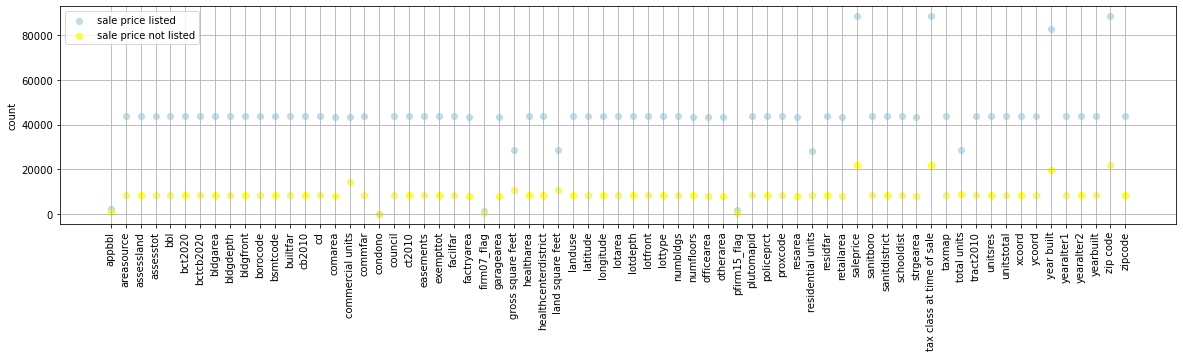

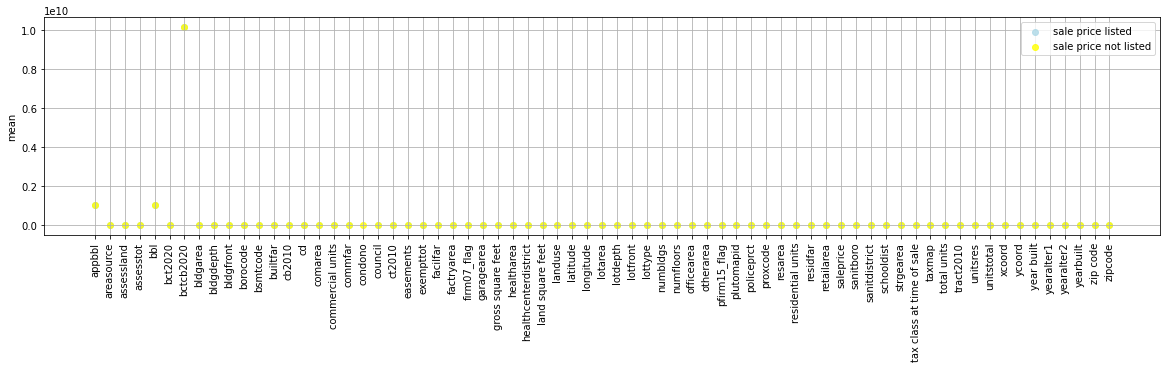

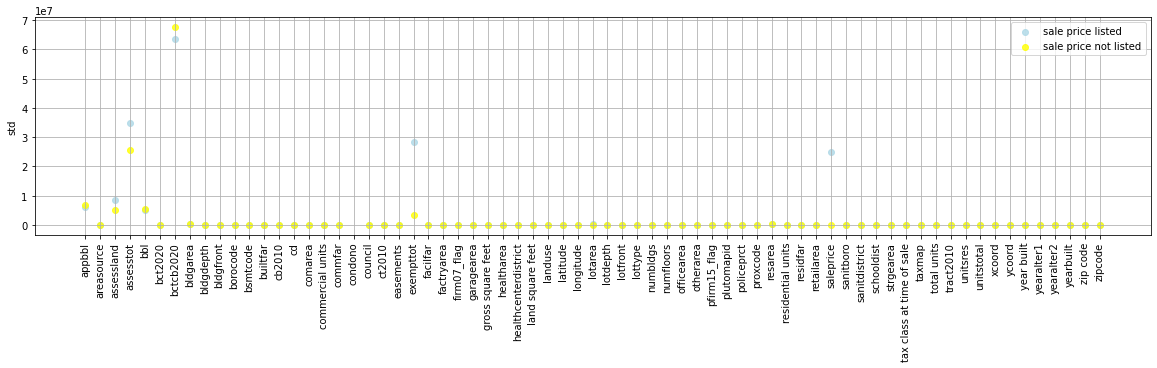

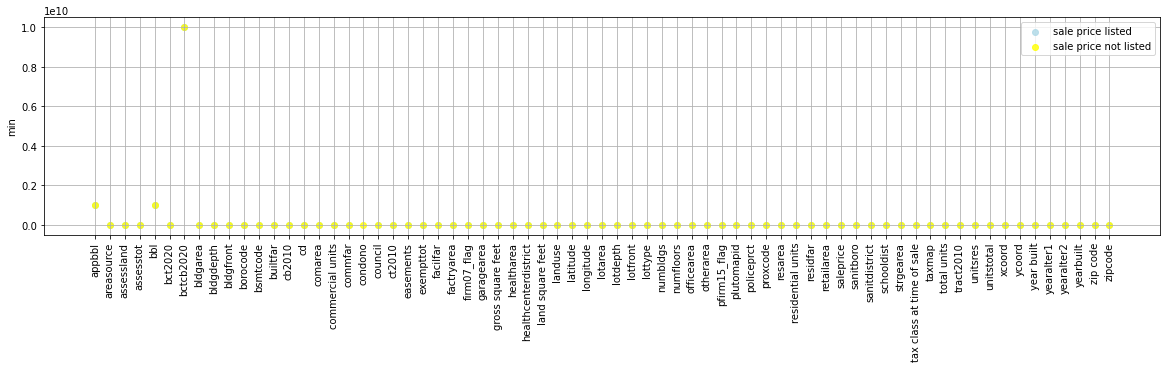

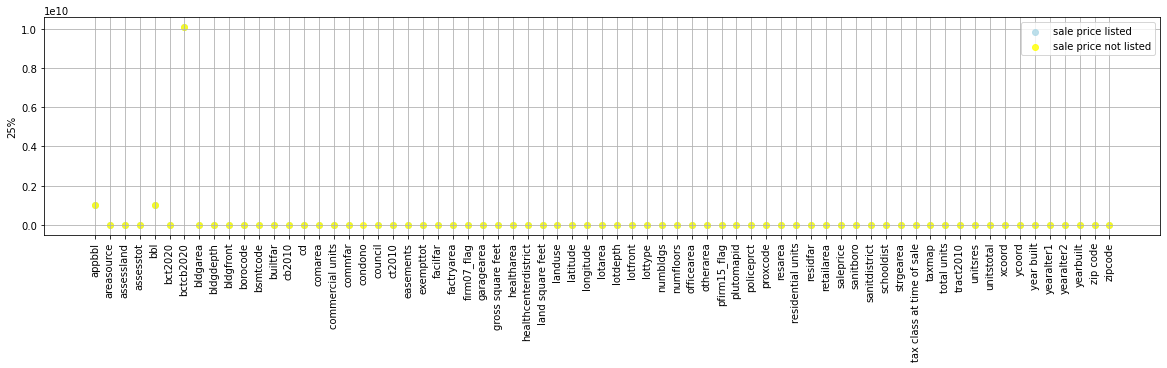

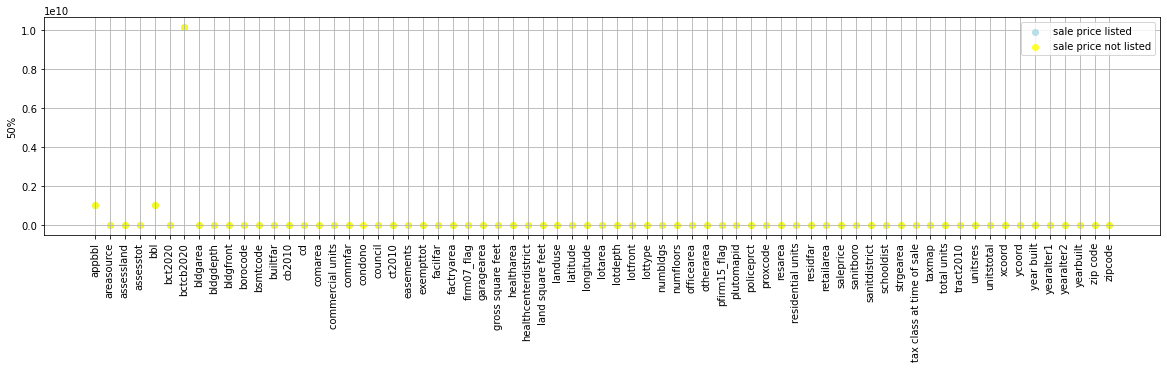

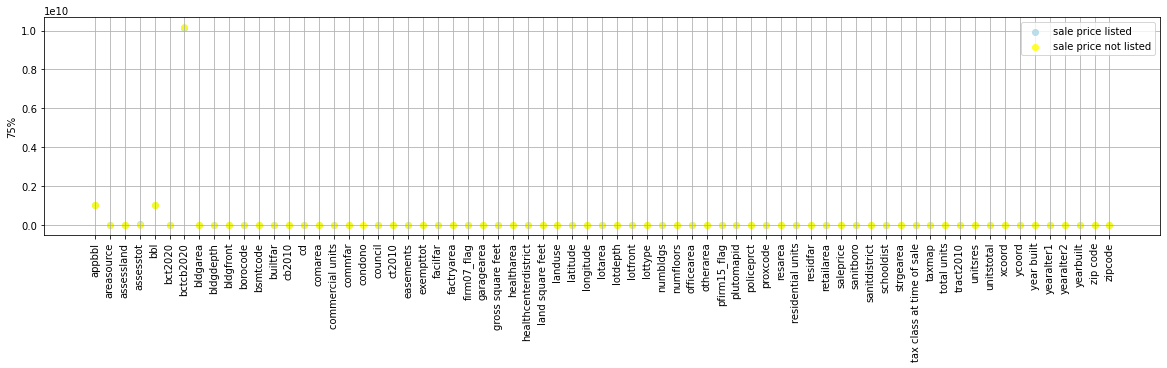

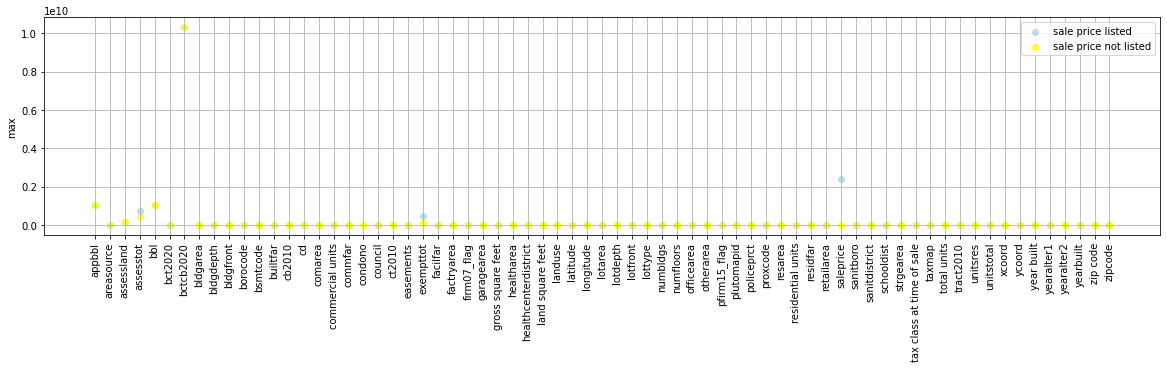

In [108]:
for i in labels:
    plt.figure(figsize=(20, 4))
    plt.scatter(non_missing_stats.index, non_missing_stats[i], label='sale price listed', color='lightblue', alpha=0.8)
    plt.scatter(missing_stats.index, missing_stats[i], label='sale price not listed', color='yellow', alpha=0.8)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.ylabel(i)
plt.show()

In [104]:
missing_stats.corr().style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
count,1.000000,-0.042808,-0.055328,-0.042854,-0.042778,-0.042785,-0.042836,-0.043491
mean,-0.042808,1.000000,0.932688,0.999999,0.999999,0.999999,1.000000,0.999169
std,-0.055328,0.932688,1.000000,0.932150,0.932187,0.932323,0.932787,0.946268
min,-0.042854,0.999999,0.932150,1.000000,1.000000,1.000000,0.999998,0.999109
25%,-0.042778,0.999999,0.932187,1.000000,1.000000,1.000000,0.999999,0.999114
50%,-0.042785,0.999999,0.932323,1.000000,1.000000,1.000000,0.999999,0.999129
75%,-0.042836,1.000000,0.932787,0.999998,0.999999,0.999999,1.000000,0.999179
max,-0.043491,0.999169,0.946268,0.999109,0.999114,0.999129,0.999179,1.000000


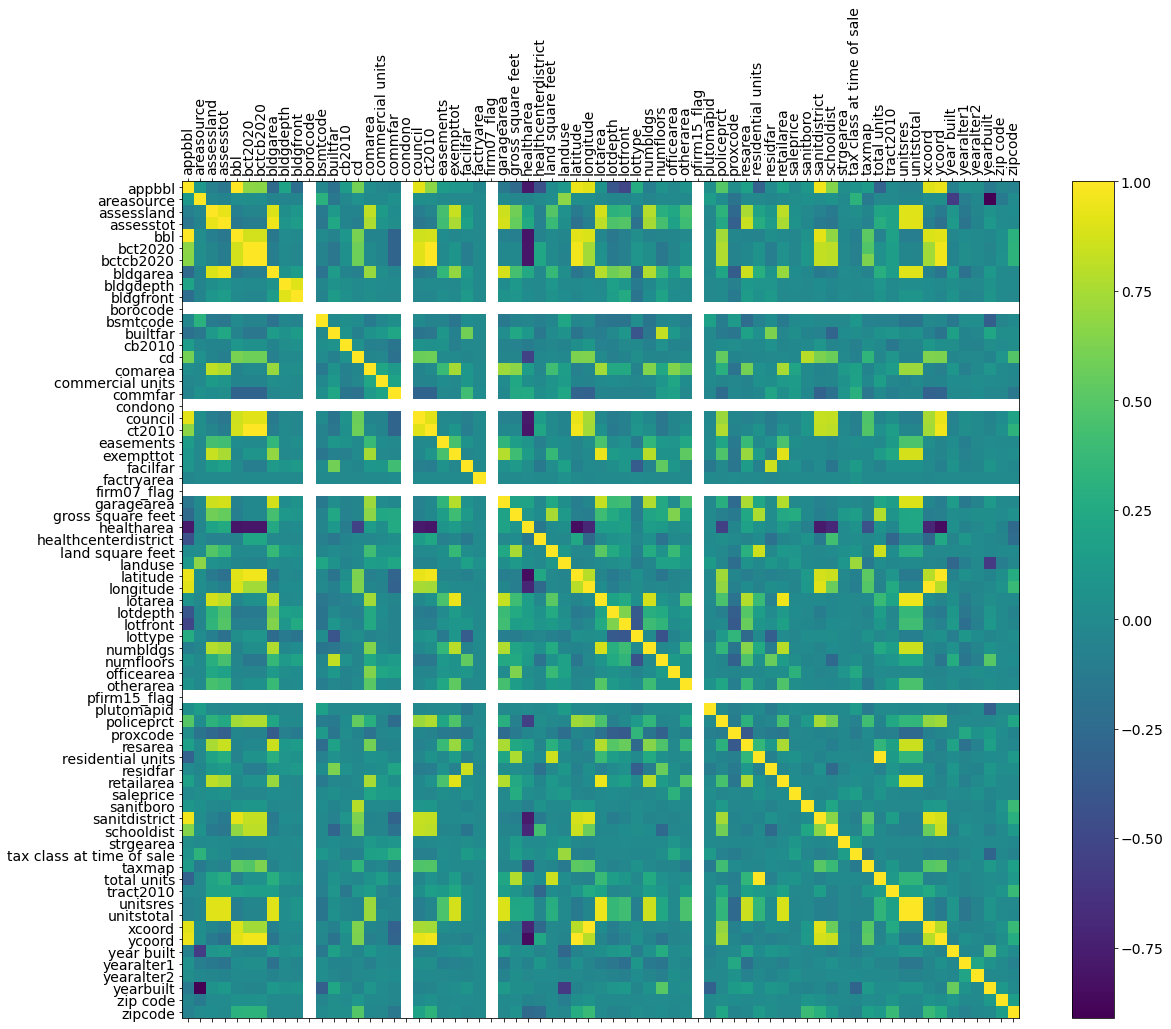

In [11]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_renamed.corr(), fignum=f.number)
plt.xticks(range(df_renamed.select_dtypes(['number']).shape[1]), df_renamed.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_renamed.select_dtypes(['number']).shape[1]), df_renamed.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.savefig('Viz_output/correlationmatrix.png')
plt.show()
#white columns and rows are NaN values

In [12]:
df_renamed.corr().style.background_gradient(cmap='coolwarm')

,appbbl,areasource,assessland,assesstot,bbl,bct2020,bctcb2020,bldgarea,bldgdepth,bldgfront,borocode,bsmtcode,builtfar,cb2010,cd,comarea,commercial units,commfar,condono,council,ct2010,easements,exempttot,facilfar,factryarea,firm07_flag,garagearea,gross square feet,healtharea,healthcenterdistrict,land square feet,landuse,latitude,longitude,lotarea,lotdepth,lotfront,lottype,numbldgs,numfloors,officearea,otherarea,pfirm15_flag,plutomapid,policeprct,proxcode,resarea,residential units,residfar,retailarea,saleprice,sanitboro,sanitdistrict,schooldist,strgearea,tax class at time of sale,taxmap,total units,tract2010,unitsres,unitstotal,xcoord,ycoord,year built,yearalter1,yearalter2,yearbuilt,zip code,zipcode
appbbl,1.000000,0.105519,-0.080156,-0.153325,1.000000,0.664773,0.660825,-0.252003,0.194639,-0.222030,nan,-0.027882,-0.191094,0.146628,0.602259,0.025546,-0.028849,-0.048482,nan,0.922345,0.664773,0.144531,0.094348,0.082394,-0.037133,nan,-0.149053,-0.248701,-0.780498,-0.437739,0.021922,0.107359,0.945797,0.913768,0.067394,-0.397098,-0.512504,0.269777,-0.089131,0.065417,-0.009364,0.059369,nan,0.037536,0.494225,0.035740,0.164704,-0.311217,0.010491,0.164916,0.003193,0.103948,0.958698,0.648996,0.031166,0.066396,0.133611,-0.310098,0.001399,-0.059354,-0.058900,0.913740,0.945803,-0.072060,0.052483,0.032968,-0.113913,-0.040820,-0.064890
areasource,0.105519,1.000000,-0.023628,-0.046188,0.028386,0.031924,0.025626,-0.045872,-0.049486,-0.051874,nan,0.310899,-0.149362,-0.022540,0.055461,-0.001129,-0.007424,0.050958,nan,0.042731,0.031924,-0.003344,-0.007910,-0.013071,-0.000094,nan,-0.001552,-0.023947,-0.030481,-0.007618,0.022922,0.667637,0.038050,0.028364,-0.011119,-0.031640,-0.043116,0.020960,-0.045004,-0.002542,-0.000436,-0.000505,nan,0.146581,0.021701,-0.177949,-0.003561,-0.010183,-0.036831,-0.000592,0.034241,0.048121,0.029332,0.064539,-0.000267,0.327845,-0.120173,-0.010757,-0.008049,-0.032369,-0.032689,0.028322,0.038053,-0.575338,-0.092365,-0.022390,-0.911261,-0.116305,0.009700
assessland,-0.080156,-0.023628,1.000000,0.938846,-0.089653,-0.038034,-0.037867,0.888027,0.043651,0.089342,nan,-0.133707,0.120499,-0.049139,-0.048887,0.815331,0.129066,0.018256,nan,-0.091515,-0.038051,0.437438,0.839917,0.129000,-0.004535,nan,0.854600,0.584935,0.201145,-0.065650,0.486485,0.051994,-0.126527,-0.034093,0.880389,0.319687,0.341376,-0.086927,0.788588,0.294590,0.237647,0.440884,nan,-0.014114,0.323867,-0.259032,0.757413,0.191678,0.101953,0.812035,0.048731,-0.012303,-0.064616,-0.112584,0.010890,0.032176,-0.035981,0.204323,0.191210,0.908837,0.910112,-0.033975,-0.126519,0.083610,-0.139112,-0.037200,0.068089,0.008491,0.014969
assesstot,-0.153325,-0.046188,0.938846,1.000000,-0.147225,-0.102243,-0.102007,0.952472,0.075473,0.143618,nan,-0.156811,0.232185,-0.047670,-0.087730,0.766163,0.081344,0.029735,nan,-0.153070,-0.102258,0.412689,0.758453,0.169621,-0.007134,nan,0.879459,0.546222,0.252172,-0.065366,0.376333,0.043632,-0.190917,-0.084046,0.811995,0.465345,0.485385,-0.201506,0.741849,0.435645,0.181628,0.406701,nan,-0.024547,0.245555,-0.325379,0.841005,0.273552,0.143770,0.760131,0.063258,-0.018290,-0.120826,-0.152707,0.006134,0.006924,-0.063769,0.278942,0.190818,0.910048,0.911292,-0.083911,-0.190909,0.123922,-0.179189,-0.047959,0.108999,0.009897,0.003261
bbl,1.000000,0.028386,-0.089653,-0.147225,1.000000,0.866382,0.866125,-0.143140,0.013077,-0.002428,nan,-0.001001,-0.057000,0.095951,0.613496,-0.048615,-0.049162,-0.298468,nan,0.859744,0.866379,0.021269,-0.020828,0.002500,-0.011541,nan,-0.073876,-0.083614,-0.802742,-0.054205,-0.007074,-0.033689,0.912048,0.890746,-0.026889,-0.145808,-0.080813,0.036193,-0.057177,-0.045100,-0.030363,-0.012769,nan,-0.013441,0.735767,-0.031270,-0.047961,-0.058077,0.039912,-0.001728,-0.028262,0.067821,0.922393,0.680238,-0.019427,-0.082890,0.521591,-0.062284,0.179993,-0.093565,-0.095072,0.890624,0.912061,-0.024150,0.018733,-0.007660,-0.015614,0.049412,0.309916
bct2020,0.664773,0.031924,-0.038034,-0.102243,0.866382,1.000000,1.000000,-0.093517,-0.0026

In [13]:
df_renamed.cov().style.background_gradient(cmap='coolwarm')

,appbbl,areasource,assessland,assesstot,bbl,bct2020,bctcb2020,bldgarea,bldgdepth,bldgfront,borocode,bsmtcode,builtfar,cb2010,cd,comarea,commercial units,commfar,condono,council,ct2010,easements,exempttot,facilfar,factryarea,firm07_flag,garagearea,gross square feet,healtharea,healthcenterdistrict,land square feet,landuse,latitude,longitude,lotarea,lotdepth,lotfront,lottype,numbldgs,numfloors,officearea,otherarea,pfirm15_flag,plutomapid,policeprct,proxcode,resarea,residential units,residfar,retailarea,saleprice,sanitboro,sanitdistrict,schooldist,strgearea,tax class at time of sale,taxmap,total units,tract2010,unitsres,unitstotal,xcoord,ycoord,year built,yearalter1,yearalter2,yearbuilt,zip code,zipcode
appbbl,38959648608345.507812,728708.308093,-14932166267135.009766,-107169496897121.671875,38959725162081.515625,35374325973.952507,351403495181694.375000,-1893450157184.451416,116007533.117510,-132854178.707186,0.000000,-252565.106365,-6803214.025794,1336545683.479969,23649462.290073,40266845781.399101,-2565497.045241,-1235163.622065,nan,14854335.702162,353730532.691645,203485.001458,63286680426129.132812,1562373.369360,-194397450.282912,0.000000,-94196901606.333450,-298361708750.148804,-11309671482.036983,-3918571.549231,3988913170.490363,1300482.400763,214717.194575,142933.326976,383636083191.457336,-520441002.544302,-631618278.925308,2521729.158742,-4670738.192380,3815884.861804,-5022212687.301111,14245398951.137236,0.000000,24416.037418,90096181.678570,254076.532012,882704558892.226929,-286546762.670360,190161.732166,123681681278.412979,1237108675785.299805,33491.980876,20300264.202463,4649801.414905,1786760824.117699,331984.335673,807337765.257964,-287385293.459511,76496718.704198,-653949206.846464,-654271639.359943,39573665533.906670,78239928280.025650,-126388506.369863,300282671.030719,80466978.571713,-306213407.515153,-112062466.536407,-23174042.453299
areasource,728708.308093,0.195769,-85082.199064,-684449.470224,63393.230784,89.196211,663512.399741,-7436.881909,-4.348824,-3.913341,0.000000,0.113561,-0.311469,-18.324364,0.106335,-2.679054,-0.054277,0.069136,nan,0.041713,0.891957,-0.000158,-91073.770113,-0.015683,-0.002210,0.000000,-1.328068,-2161.032618,-23.968930,-0.004939,472.469733,0.295743,0.000539,0.000241,-1077.476510,-1.371865,-2.316526,0.010268,-0.046309,-0.000829,-0.625179,-0.156838,0.000000,0.003377,0.093274,-0.081571,-30.057457,-0.537844,-0.048992,-0.527802,401770.735131,0.000722,0.034170,0.033898,-0.038801,0.068323,-17.031747,-0.574556,-17.719752,-6.532993,-6.653209,66.634080,196.364863,-18.106265,-40.213869,-4.857412,-73.571374,-9.468008,0.160697
assessland,-14932166267135.009766,-85082.199064,66233431145064.304688,255902586328276.281250,-3682753503161.870117,-1988379134.352660,-19810964759064.843750,2648133937116.829102,70640386.435379,124111512.272199,0.000000,-898317.857856,4701451.607728,-747506423.206942,-1753862.841928,508464035311.007202,7487995.808659,455588.394645,nan,-1671636.811775,-19893085.315491,380686.621611,177884138664277.437500,2846857.694873,-27911433.788665,0.000000,192238416332.362915,389861518776.437866,2959641905.671286,-796534.511870,69768748737.929703,427771.239324,-34084.786727,-5512.219061,1570977663069.755615,255252008.859024,337745220.858860,-783282.189979,14942630.189183,20097805.431282,89497721939.039383,35965097673.846634,0.000000,-5980.760760,26046814.298028,-2184057.745980,1680294351117.927734,93115244.216695,2494487.542779,190368626101.264496,10517269057209.957031,-3452.624448,-1408489.295344,-1106453.670582,415777854.217310,123337.481512,-95300538.491618,100319784.799550,7876593876.475910,3373886219.747206,3407189239.288970,-1520499504.554796,-12419116802.376482,68482846.628809,-1114040358.128229,-148446514.169373,101113746.507188,12714322.531120,4640246.339754
assesstot,-107169496897121.671875,-684449.470224,255902586328276.281250,1121717760378486.125000,-24888125661522.015625,-21997038515.655319,-219592197454837.062500,11688783007950.500000,502597128.268076,820988408.90294

In [14]:
ex_df = df_renamed.copy()

In [2]:
#ex_df = df[['saleprice', 'YEAR BUILT', 'schooldist', 'council', 'policeprct', 'numfloors', 'histdist']]

In [15]:
ex_df.dtypes

apartment number     object
appbbl              float64
appdate              object
areasource          float64
assessland          float64
                     ...   
zmcode               object
zonedist1            object
zonedist2            object
zonedist3            object
zonemap              object
Length: 104, dtype: object

#### 2. EDA and Preprocessing <a class="anchor" id="bullet2"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [16]:
pd.DataFrame(ex_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
appbbl,2642.0,1.009640e+09,6.241766e+06,1.000020e+09,1.004540e+09,1.010090e+09,1.014030e+09,1.022430e+09
areasource,52240.0,2.039433e+00,4.424577e-01,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00
assessland,52240.0,3.100737e+06,8.138392e+06,0.000000e+00,4.063500e+05,1.318500e+06,3.452850e+06,1.725093e+08
assesstot,52240.0,1.830963e+07,3.349206e+07,0.000000e+00,2.229862e+06,9.025650e+06,2.250045e+07,7.041114e+08
bbl,52241.0,1.012232e+09,5.047478e+06,1.000020e+09,1.008670e+09,1.013210e+09,1.015140e+09,1.022500e+09
...,...,...,...,...,...,...,...,...
yearalter1,52240.0,1.137042e+03,9.840061e+02,0.000000e+00,0.000000e+00,1.981000e+03,1.987000e+03,2.021000e+03
yearalter2,52240.0,1.280808e+02,4.903256e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.021000e+03
yearbuilt,52240.0,1.916042e+03,1.824712e+02,0.000000e+00,1.910000e+03,1.929000e+03,1.960000e+03,2.022000e+03
zip code,110226.0,1.001317e+04,4.122725e+02,0.000000e+00,1.001300e+04,1.002200e+04,1.002800e+04,1.046300e+04


##### Get rid of outliers and missing data

In [17]:
#MISSING AND ZERO DATA 

missing = pd.DataFrame(ex_df.isna().sum()).rename(columns={0: 'missing_count'})
zeros = pd.DataFrame((ex_df == 0).astype(int).sum(axis=0)).rename(columns={0: 'zero_count'})
problems = pd.concat((missing, zeros), axis=1)
problems['missing_pct'] = problems.missing_count / len(ex_df) * 100
problems['zero_pct'] = problems.zero_count / len(ex_df) * 100
dtypes = list(ex_df.dtypes)
problems['type'] = dtypes

display(problems.sort_values('missing_pct', ascending=False).head(50))

,missing_count,zero_count,missing_pct,zero_pct,type
condono,110225,0,99.999093,0.000000,float64
spdist2,110165,0,99.944659,0.000000,object
overlay2,110010,0,99.804039,0.000000,object
edesignum,109536,0,99.374013,0.000000,object
zonedist3,109310,0,99.168980,0.000000,object
landmark,108978,0,98.867781,0.000000,object
ltdheight,108801,0,98.707202,0.000000,object
ownertype,108654,0,98.573839,0.000000,object
firm07_flag,108638,0,98.559324,0.000000,float64
pfirm15_flag,107949,0,97.934244,0.000000,float64


In [18]:

beg = ex_df.shape[0]
print("Starting length: {}".format(beg))
ex_df = ex_df[ex_df['saleprice'] != 0]
ex_df = ex_df[ex_df['saleprice'] != 1]
ex_df = ex_df[ex_df['saleprice'] != math.e]
end = ex_df.shape[0]
print("Ending length: {}".format(end))

missing = (beg-end)/beg
print("Percentage missing: {:.3f}".format(missing*100))

Starting length: 110226
Ending length: 88224
Percentage missing: 19.961


In [19]:
#OUTLIERS: YEAR BUILT

import math

#look at year-built outlier
sub = ex_df[ex_df['year built'] == 1111]
display(sub[['apartment number', 'appbbl', 'saleprice', 'year built']])

#drop outlier. Commercial garage in Chelsea built in 1111? I think not.
allsales = ex_df[ex_df['year built'] != 1111]

,apartment number,appbbl,saleprice,year built
978,,1.007990e+09,8208750.0,1111.0
53869,NaN,1.007990e+09,7680000.0,1111.0


##### EDA and visualization

In [20]:
ex_df.describe()

,appbbl,areasource,assessland,assesstot,bbl,bct2020,bctcb2020,bldgarea,bldgdepth,bldgfront,...,unitsres,unitstotal,xcoord,ycoord,year built,yearalter1,yearalter2,yearbuilt,zip code,zipcode
count,1.990000e+03,43727.000000,4.372700e+04,4.372700e+04,4.372800e+04,4.366800e+04,4.360100e+04,4.372700e+04,43684.000000,43684.000000,...,43727.000000,43727.000000,4.366600e+04,43666.000000,82356.000000,43727.000000,43727.000000,43727.000000,88224.000000,43670.000000
mean,1.009413e+09,2.026482,3.193703e+06,1.897042e+07,1.012196e+09,1.012680e+06,1.012679e+10,1.949093e+05,112.388331,102.839227,...,175.384568,178.327784,9.920998e+05,219004.186552,1878.663534,1152.390056,124.891669,1922.177762,10011.237350,10030.805931
std,6.063567e+06,0.363365,8.591536e+06,3.481088e+07,4.970173e+06,6.347761e+03,6.345561e+07,3.761893e+05,186.386740,160.374379,...,487.225120,491.369004,5.435999e+03,11902.883581,378.204067,981.508185,484.562769,154.569792,434.974545,33.887474
min,1.000160e+09,0.000000,0.000000e+00,0.000000e+00,1.000050e+09,1.000201e+06,1.000201e+10,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,9.797770e+05,195317.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10001.000000
25%,1.004205e+09,2.000000,4.680000e+05,2.758500e+06,1.008710e+09,1.007800e+06,1.007800e+10,3.168950e+04,79.000000,50.000000,...,28.000000,30.000000,9.882770e+05,210002.000000,1920.000000,0.000000,0.000000,1914.000000,10013.000000,10014.000000
50%,1.010170e+09,2.000000,1.431000e+06,9.839250e+06,1.013130e+09,1.012700e+06,1.012700e+10,1.001370e+05,90.000000,95.000000,...,80.000000,81.000000,9.922620e+05,219040.000000,1952.000000,1981.000000,0.000000,1929.000000,10022.000000,10023.000000
75%,1.013920e+09,2.000000,3.514500e+06,2.283615e+07,1.015090e+09,1.016002e+06,1.016002e+10,2.104680e+05,127.000000,128.420000,...,185.000000,189.000000,9.960600e+05,224408.000000,1984.000000,1987.000000,0.000000,1960.000000,10028.000000,10030.000000
max,1.022410e+09,7.000000,1.725093e+08,7.041114e+08,1.022500e+09,1.031703e+06,1.031703e+10,8.942176e+06,9388.000000,7538.000000,...,8764.000000,8812.000000,1.009402e+06,259200.000000,2021.000000,2021.000000,2021.000000,2022.000000,10463.000000,10463.000000


In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\lproc\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


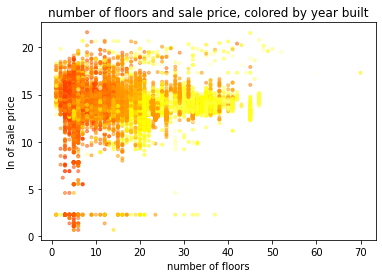

In [118]:
plt.scatter(ex_df.numfloors, np.log(ex_df.saleprice), alpha=0.5, c=np.log(ex_df['year built']), cmap='hot', marker='.')
plt.xlabel("number of floors")
plt.ylabel("ln of sale price")
plt.title("number of floors and sale price, colored by year built")
plt.savefig("Viz_output/floors_and_sale_price.jpg")
plt.show()

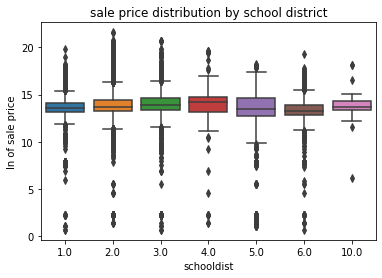

In [119]:
sns.boxplot(x='schooldist', y=np.log(ex_df.saleprice), data=ex_df)
plt.ylabel("ln of sale price")
plt.title("sale price distribution by school district")
plt.savefig("Viz_output/sale_price_and_school_dist.jpg")
plt.show()

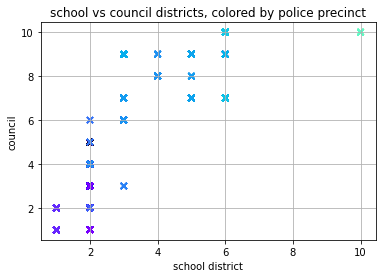

In [120]:
plt.scatter(ex_df.schooldist, ex_df.council, c=ex_df.policeprct, cmap='rainbow', alpha=0.5, marker='x')
plt.grid()
plt.xlabel("school district")
plt.ylabel("council")
plt.title("school vs council districts, colored by police precinct")
plt.savefig("Viz_output/school dist city council dist police prct.jpg")
plt.show()

##### Split data into X and y, train test split

In [21]:
y = ex_df['saleprice']
X = ex_df.select_dtypes([np.number]).drop('saleprice', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) #update to go chronologically
X_train.head()

,appbbl,areasource,assessland,assesstot,bbl,bct2020,bctcb2020,bldgarea,bldgdepth,bldgfront,...,unitsres,unitstotal,xcoord,ycoord,year built,yearalter1,yearalter2,yearbuilt,zip code,zipcode
102194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1920.0,NaN,NaN,NaN,10013,NaN
66325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2008.0,NaN,NaN,NaN,10009,NaN
81134,NaN,2.0,5580000.0,38761200.0,1.014500e+09,1013400.0,1.013401e+10,386435.0,100.0,204.33,...,369.0,374.0,996773.0,219931.0,1966.0,0.0,0.0,1966.0,10021,10021.0
102018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2006.0,NaN,NaN,NaN,10007,NaN
86211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016.0,NaN,NaN,NaN,10023,NaN


##### Create and fit preprocessing pipeline

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = X_train.select_dtypes([np.number])
numeric_features = numeric_features.columns.tolist()

categorical_features = X_train.select_dtypes([object])
categorical_features = categorical_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocess=preprocessor.fit(X_train) 

def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

##### PCA to reduce dimensionality, assess clusters

In [158]:
ex_df_copy = ex_df.copy()

In [124]:
#PCA

from sklearn.decomposition import PCA

#2 PCs
pca = PCA(n_components=2)
pca.fit_transform(preprocessor(ex_df_copy))
print(pca.components_)
print(pca.explained_variance_ratio_)

#to take it from 2 features to 1
pca = PCA(n_components=1)
pca.fit((preprocessor(ex_df_copy)))

X_pca = pca.transform(preprocessor(ex_df_copy)) # create X data with single pca vector
print("original shape:   ", preprocessor(ex_df_copy).shape)
print("transformed shape:", X_pca.shape)

[[-3.76116625e-02 -5.44748063e-03  1.91790929e-01  2.02092517e-01
  -6.60275981e-02 -3.81093653e-02 -3.80724828e-02  1.98171068e-01
   2.18695699e-02  2.56223776e-02 -0.00000000e+00 -5.17727010e-02
   2.98608854e-02 -1.66128819e-02 -4.31825656e-02  1.72985606e-01
   2.45878555e-02  3.11702239e-02 -5.07897313e-02 -3.81135299e-02
   8.95210244e-02  1.67438676e-01  2.50982357e-02  3.01286766e-04
  -0.00000000e+00  1.81230235e-01  2.14185507e-01  8.47962674e-02
  -7.57260752e-03  2.44957840e-01  1.69188619e-02 -6.74550310e-02
  -4.82981753e-02  1.77795633e-01  9.87123817e-02  9.11291828e-02
  -4.42713135e-02  1.67332556e-01  6.76464995e-02  4.97928319e-02
   1.25497100e-01 -0.00000000e+00 -1.24712136e-03  2.77174782e-02
  -6.04639320e-02  1.88209354e-01  4.37136817e-01  1.05617225e-02
   1.63126700e-01 -6.78725676e-03 -6.04993472e-02 -3.51101460e-02
   5.50307714e-03  6.14248351e-03 -4.47567792e-02  4.31879303e-01
   5.47209630e-02  1.94155033e-01  1.94438104e-01 -4.82755784e-02
  -6.74530

Text(0.5, 1.0, 'Elbow curve')

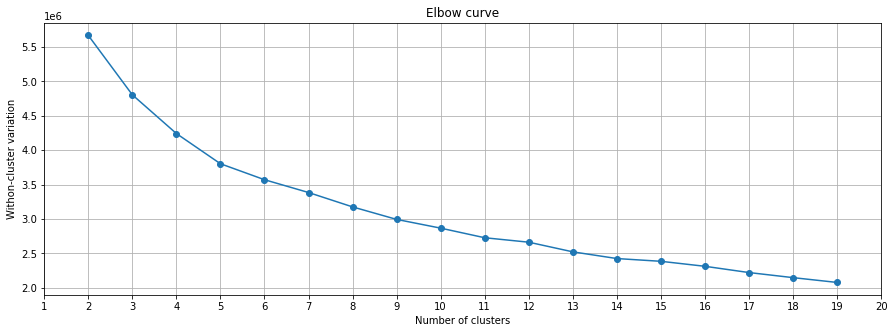

In [125]:
#use an elbow curve to figure out roughly how many clusters to look for
from sklearn.cluster import KMeans

within_cluster_variance = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(preprocessor(ex_df))
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.ylabel('Withon-cluster variation')
plt.title('Elbow curve') 

In [71]:
km1 = KMeans(n_clusters=4, random_state=0)
#km2 = KMeans(n_clusters=7, random_state=SEED)

models = [km1] #, km2]

for model in models:
    ex_df['cluster'] = model.fit_predict(preprocessor(ex_df))
    print("KMeans Clusters: "+str(model.n_clusters))
    print("Value counts:")
    print(pd.Series(model.labels_).value_counts())
    print("Inertia: {}".format(model.inertia_))
    display(ex_df.groupby('cluster').mean().sort_values('saleprice', ascending=False))
    print("\n")

KMeans Clusters: 6
Value counts:
0    56561
4    13274
5    12977
3     5279
1      132
2        1
dtype: int64
Inertia: 3570974.7606461016


,appbbl,areasource,assessland,assesstot,bbl,bct2020,bctcb2020,bldgarea,bldgdepth,bldgfront,...,unitstotal,xcoord,ycoord,year built,yearalter1,yearalter2,yearbuilt,zip code,zipcode,zonedist4
cluster,,,,,,,,,,,,,,,,,,,,,
5,1.004077e+09,2.024892,2.832249e+06,2.077148e+07,1.006132e+09,1.005970e+06,1.005960e+10,2.264465e+05,106.208661,97.676453,...,206.110512,9.859207e+05,206319.565328,1933.329907,1181.513409,137.360512,1919.677790,10010.297372,10011.784553,NaN
4,1.013061e+09,2.001130,5.080937e+06,2.903394e+07,1.013509e+09,1.013016e+06,1.013017e+10,2.630970e+05,147.483238,137.482181,...,204.932952,9.938705e+05,219626.836586,1948.180106,924.355884,118.104415,1947.308724,10040.483803,10041.095532,NaN
0,1.013386e+09,2.017404,1.155446e+06,6.490496e+06,1.013715e+09,1.014415e+06,1.014416e+10,6.377762e+04,85.087536,76.508214,...,62.942069,9.931550e+05,221960.609344,1842.631790,1357.114205,110.480524,1914.572435,10003.892435,10037.846570,NaN
3,1.018295e+09,2.115574,6.899431e+05,5.877848e+06,1.020289e+09,1.024095e+06,1.024099e+10,1.291687e+05,104.016661,90.778901,...,107.442592,1.000315e+06,241979.760940,1914.792315,1215.309208,147.399015,1881.181508,10017.885206,10035.333018,NaN
2,NaN,2.000000,1.174500e+08,7.041114e+08,1.009720e+09,1.004400e+06,1.004401e+10,8.942176e+06,2023.000000,1362.000000,...,8812.000000,9.903760e+05,205864.000000,1945.000000,0.000000,0.000000,1945.000000,10009.000000,10009.000000,NaN
1,1.013730e+09,2.000000,1.345064e+08,4.890204e+08,1.013730e+09,1.023804e+06,1.023804e+10,4.786701e+06,0.000000,0.000000,...,8088.000000,9.967920e+05,215349.000000,1975.000000,0.000000,0.000000,1975.000000,10044.000000,10044.000000,NaN


#### 3. Hedonic (OLS) model<a class="anchor" id="bullet3"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [169]:
import math

nonzero_meds = list([i for i in X_train.columns if math.isnan(X_train[i].median())])
all_cols = list(X_train.columns)

print("total columns: {}".format(len(all_cols)))
print("number of columsn where median isn't NaN: {}".format(len(nonzero_meds)))

ignore_cols = []
use_these_cols = []

for i in list(all_cols):
    if i in nonzero_meds:
        ignore_cols.append(i)
    else:
        use_these_cols.append(i)
print("columns with NaN median: {}".format(ignore_cols))

total columns: 68
number of columsn where median isn't NaN: 1
columns with NaN median: ['condono']


In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error


lr = LinearRegression().fit(preprocessor(X_train), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor(X_train), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor(X_train), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor(X_test), y_test)))

Train set score: 0.23999
Mean cross-val score for train set: 0.15605
Test set score: -2.39011.


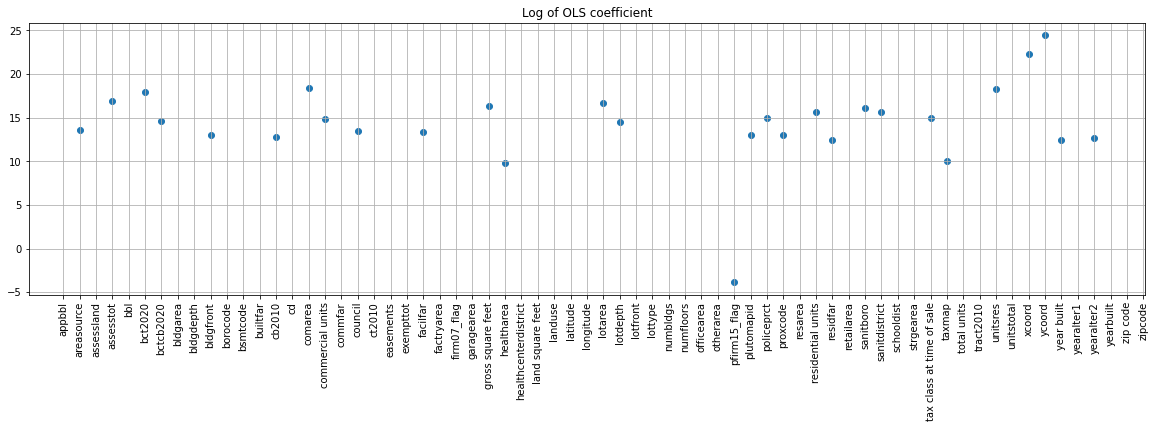

In [178]:
plt.figure(figsize=(20, 5))
plt.scatter(use_these_cols, np.log(lr.coef_))
plt.xticks(rotation=90)
plt.grid()
plt.title("Log of OLS coefficient")
plt.savefig("Viz_output/olscoefs.png")
plt.show()

#### 4. Random Forest model<a class="anchor" id="bullet4"></a>

[Back to top]<a class="anchor" id="bullet0"></a>

In [179]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statistics import mean

forest = RandomForestRegressor()

forest.fit(preprocessor(X_train),y_train)

print("Train set score: {:.5f}".format(forest.score(preprocessor(X_train), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(forest, preprocessor(X_train), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(forest.score(preprocessor(X_test), y_test)))

Train set score: 0.83538
Mean cross-val score for train set: 0.34949
Test set score: -0.20755.


In [16]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'max_depth': [10, 15, 20, 25],
              'n_estimators': [10, 30, 50, 100]}

grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, cv=10)

grid.fit(preprocessor(X_train), y_train)

print("best median cross-val score: {}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {}".format(grid.score(preprocessor(X_test), y_test)))

#view results
results = pd.DataFrame(grid.cv_results_)
results

best median cross-val score: 0.3621028070770386
best parameters: {'max_depth': 10, 'n_estimators': 10}
test-set score: -0.3341258232915898


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,5.341138,0.239057,0.008379,0.007365,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.720841,0.476814,0.320726,-0.169650,0.475469,-0.014028,0.486675,0.396488,0.653224,0.274469,0.362103,0.262637,1
1,16.733777,1.401609,0.022291,0.010160,10,30,"{'max_depth': 10, 'n_estimators': 30}",0.683788,0.547348,0.299439,-0.080422,0.526562,-0.920442,0.524321,0.497292,0.672640,0.301943,0.305247,0.460634,6
2,30.293048,6.191632,0.031763,0.010219,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.727177,0.546262,0.295268,0.093464,0.546991,-1.146854,0.520705,0.505214,0.651889,0.291038,0.303115,0.515250,7
3,69.704843,13.776985,0.068055,0.015849,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.681702,0.552704,0.322808,0.007895,0.489222,-1.059033,0.520541,0.477448,0.643544,0.306857,0.294369,0.487448,10
4,15.216919,3.981479,0.027265,0.013384,15,10,"{'max_depth': 15, 'n_estimators': 10}",0.745094,0.411064,0.279958,0.234574,0.467055,-1.155254,0.522783,0.584539,0.617010,0.290398,0.299722,0.509115,8
5,36.876025,8.060100,0.038922,0.007094,15,30,"{'max_depth': 15, 'n_estimators': 30}",0.714985,0.514889,0.332696,-0.011660,0.617791,-1.774760,0.529213,0.423769,0.661446,0.314061,0.232243,0.698212,15
6,34.549845,0.491981,0.048989,0.009296,15,50,"{'max_depth': 15, 'n_estimators': 50}",0.756489,0.549130,0.299631,-0.238237,0.592633,-0.544797,0.582205,0.460514,0.679585,0.306414,0.344357,0.398663,2
7,68.275979,0.521963,0.092683,0.006314,15,100,"{'max_depth': 15, 'n_estimators': 100}",0.746947,0.545991,0.318149,-0.003710,0.602489,-0.907533,0.560641,0.391775,0.666486,0.313159,0.323439,0.459111,3
8,7.800888,0.079057,0.015567,0.001610,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.733132,0.531390,0.329170,0.052990,0.609836,-1.398582,0.592947,0.526365,0.607450,0.300174,0.288487,0.592828,11
9,23.773002,0.552251,0.048274,0.003046,20,30,"{'max_depth': 20, 'n_estimators': 30}",0.765377,0.549725,0.301893,0.101240,0.600169,-0.898010,0.575570,0.256001,0.633369,0.283924,0.316926,0.450575,5


In [33]:
#pull out best hyperparams

best_max_depth = grid.best_params_['max_depth']
best_n_estimators = grid.best_params_['n_estimators']

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#use best params to run forest and get feature importances

best_forest = RandomForestRegressor(max_depth = best_max_depth,
                                    n_estimators = best_n_estimators).fit(preprocessor(X_train), y_train)

In [96]:
df_first_col = pd.DataFrame(use_these_cols).rename({0:'label'}, axis=1)
df_sec_col = pd.DataFrame(best_forest.feature_importances_).rename({0:'importance'}, axis=1)
df_from_best_forest = pd.concat((df_first_col, df_sec_col), axis=1)

df_sorted = df_from_best_forest.sort_values('importance', ascending=False)
df_sorted.head()

,label,importance
26,gross \nsquare feet,0.171135
61,year built,0.164199
39,officearea,0.106410
3,assesstot,0.077105
13,cb2010,0.068780


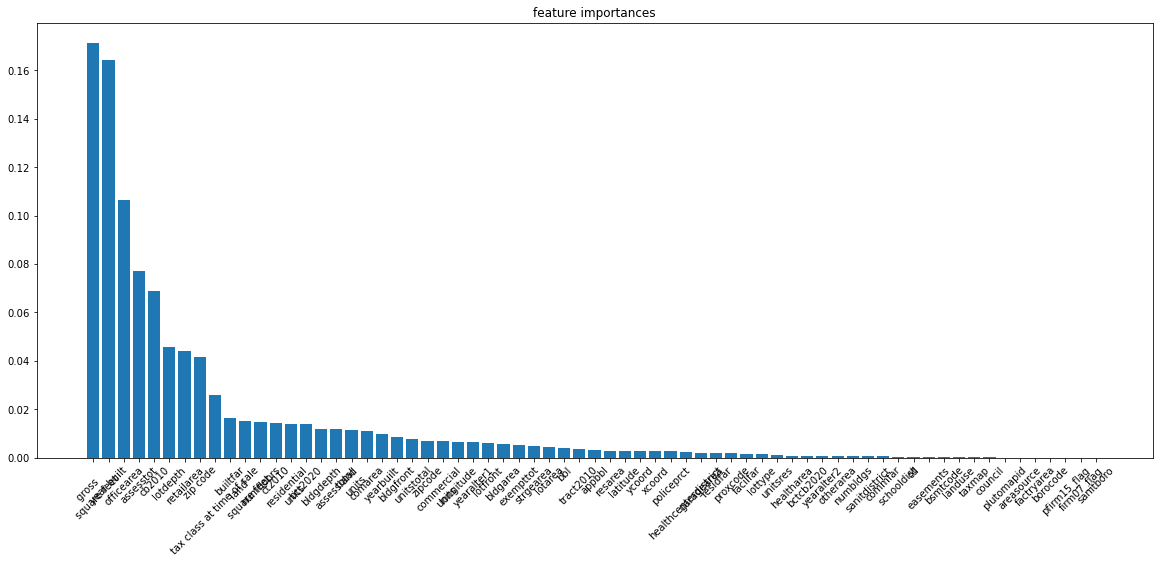

In [101]:
#visualize feature importances

plt.figure(figsize=(20, 8))
plt.title("feature importances")
plt.xticks(rotation=45)
plt.bar(df_sorted.label, df_sorted.importance)
plt.savefig('Viz_output/feature importances for all feat.png')
plt.show()

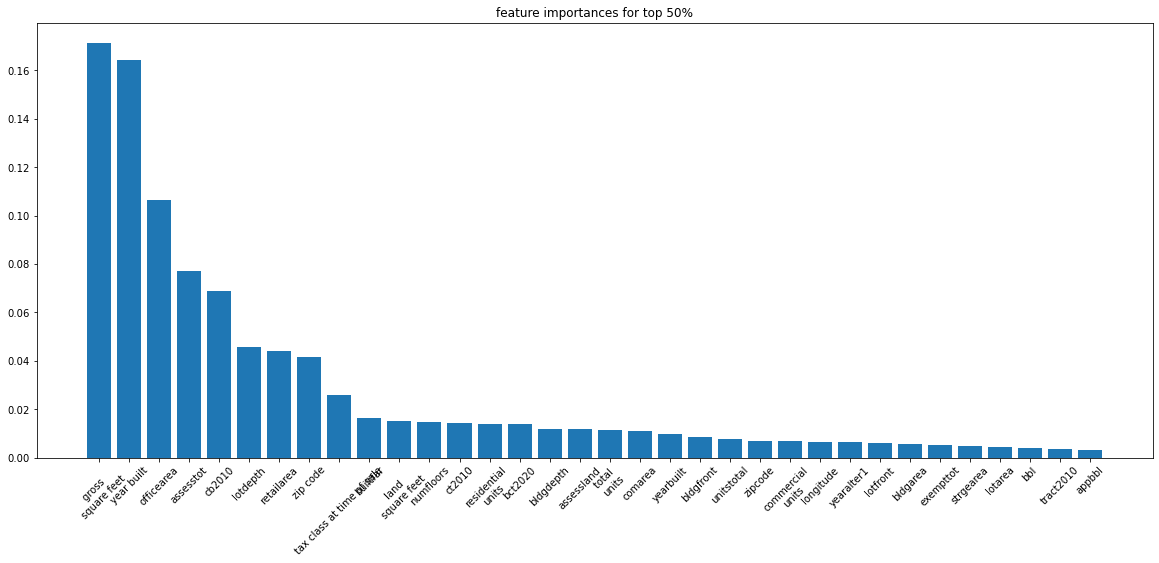

In [104]:
#visualize feature importances

plt.figure(figsize=(20, 8))
plt.title("feature importances for top 50%")
plt.xticks(rotation=45)
plt.bar(df_sorted.label[0:34], df_sorted.importance[0:34])
plt.savefig('Viz_output/feature importances for top 50 feat.png')
plt.show()

# Outstanding questions

1. Should I preprocess differently for RF vs. OLS?
2. Visualize OLS coeffs (does standardized mean they're comparable?)
3. Get rid of overlapping variables (e.g., year built vs. yearbuilt)
4. Use NLP to clean characters and \n out of column names

In [120]:
#MISSING AND ZERO DATA 

for i in [non_missing_stats.T, missing_stats.T]:

    missing = pd.DataFrame(i.isna().sum()).rename(columns={0: 'missing_count'})
    zeros = pd.DataFrame((i == 0).astype(int).sum(axis=0)).rename(columns={0: 'zero_count'})
    problems = pd.concat((missing, zeros), axis=1)
    problems['missing_pct'] = problems.missing_count / len(i) * 100
    problems['zero_pct'] = problems.zero_count / len(i) * 100
    dtypes = list(i.dtypes)
    problems['type'] = dtypes

    display(problems.sort_values('missing_pct', ascending=False).head(50).style.background_gradient(cmap='coolwarm'))

,missing_count,zero_count,missing_pct,zero_pct,type
condono,7,1,87.500000,12.500000,float64
appbbl,0,0,0.000000,0.000000,float64
policeprct,0,0,0.000000,0.000000,float64
saleprice,0,0,0.000000,0.000000,float64
retailarea,0,3,0.000000,37.500000,float64
residfar,0,1,0.000000,12.500000,float64
residential units,0,2,0.000000,25.000000,float64
resarea,0,1,0.000000,12.500000,float64
proxcode,0,1,0.000000,12.500000,float64
plutomapid,0,0,0.000000,0.000000,float64


,missing_count,zero_count,missing_pct,zero_pct,type
condono,1,0,12.500000,0.000000,float64
appbbl,0,0,0.000000,0.000000,float64
policeprct,0,0,0.000000,0.000000,float64
saleprice,0,7,0.000000,87.500000,float64
retailarea,0,3,0.000000,37.500000,float64
residfar,0,1,0.000000,12.500000,float64
residential units,0,1,0.000000,12.500000,float64
resarea,0,1,0.000000,12.500000,float64
proxcode,0,1,0.000000,12.500000,float64
plutomapid,0,0,0.000000,0.000000,float64
